In [1]:
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
#nltk.download('punkt')
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

### Methodology:

The goal of this notebook is to apply the Singular Value Decomposition (SVD) to text data. This technique is known as Latent Semantic Analysis (LSA). In order to show my audience the impact of this method I chose two extremely different article categories to analyze: 3 essays/articles about Trump's Immigration policy and a St. Patrick's Day team bonding activity. 

#### Reviewing the Singular Value Decomposition (SVD)

The SVD can decompose **any** matrix A into three matrices, U, ∑, V. U and V are orthonormal and ∑ is diagonal. We do this decomposition by doing A^T * A and A * A^T. When we multiply A^T * A or A * A^T we can turn a potentially rectangular matrix of data into a **square matrix.** This is helpful because we can now analyze what's happening in this matrix using eigenvectors and eigenvalues. This is *because* our matrix is square and we can only take eigenthings of square matrices. 

Furthermore when we decompose A into three matrices the entries of U and V are the eigenvectors of A * A^T and A^T * A, respectively. The eigenvalues are the **same** between these two matrices. One of the important facts in linear algebra is BA and AB have the same eigenvalues. This is because their "characteristic polynomial" is the same. The eigenvalues are in ∑ and are ordered in descending order. 

You may be wondering *how* we know the matrices U and V are orthonormal or what the sign of the eigenvalues is (or whether they are real or complex!). We know these properties because of the spectral theorem. When we multiply A * A^T (or A^T * A) we get a symmetric, positive definite matrix. Let's talk about symmetric matrices first. Recall the definition of a symmetric matrix is A^T = A. We **know** we get a symmetric matrix because we are multiplying the transpose by itself. We can prove this to ourself by doing matmul. Now, the [spectral theorem](https://www.youtube.com/watch?v=UCc9q_cAhho&pp=ygUdc3ltbWV0cmljIG1hdHJpY2VzIGdpbCBzdHJhbmc%3D) states that for symmetric matrices the eigenvectors are orthogonal and the eigenvalues are real. See the link for a proof. 

Positive definiteness is the second property from above. This guarantees that all the eigenvalues are positive, not just real. We know a matrix is positive definite by a few properties. If all the pivots are positive, if all the eigenvalues are positive, if all the upper left determinants are positive, if x^T * A * x > 0, or if A = R^T * R where R has independent columns. We can takeaway that it's much harder to check for positive definiteness than it is for symmetry (you can just look at the matrix or use `np.transpose(A)` and `assert np.transpose(A) == A`. In the practice problems I've done on 1x1 to 4x4 matrices I have found it simplest to calculate the "sub-determinants" of the matrix. If you are more curious about proofs of these properties see [this link](https://www.math.utah.edu/~zwick/Classes/Fall2012_2270/Lectures/Lecture33_with_Examples.pdf). 

Two more things: (1) Because the SVD has orthonormal vectors it gives us the **best basis** when we are reconstructing the matrix A. By best I mean we have completely independent axes that represent our column vectors of A. (2) We can decompose the matrix A into a sum of rank-one matrices from the SVD. When we have rank one matrices we are doing an "outer product" which is row vector * column vector (x^T * x). We call this rank one because the resulting matrix of this row-column vector multiplication will give us a matrix where the row and column entries are multiplies of the first row/first column. I think this is important to give us another perspective on how we can write the matrix A. Later on in this lesson we'll relate low-rank approximations to sum of rank-one matrices.  

#### More notes on methodology

In order to get the data for this analysis I scraped three Trump articles of various lengths (2 from Substack authors and one from CNBC) and one St. Patrick's Day article. I tokenized each of the sentences and concatenated the sentences from all the articles into a dataframe called `concat_df`. These sentences in the language of Latent Semantic Analysis (LSA) are called documents. I'll refer to them as such for the rest of the notebook. 

In [2]:
response = requests.get('https://thepreamble.com/p/trump-promised-the-biggest-deportation')
soup = BeautifulSoup(response.content, 'html.parser')

p_tags_article1 = soup.find_all(lambda tag: tag.name == 'p' and not tag.find_parent(class_="sideBySideWrap-vGXrwP"))
clean_text_article1 = [el.text.strip() for el in p_tags_article1]
clean_text_article1 = clean_text_article1[:32]

sentences_clean_text_article1 = []
for paragraph in clean_text_article1:
    sentences_clean_text_article1.extend(sent_tokenize(paragraph))

trump1_df = pd.DataFrame(sentences_clean_text_article1, columns = ['Sentence'])
trump1_df['Title'] = 'Substack post: Trump Promised the Biggest Deportation Operation in History. It’s Not Happening.'

In [3]:
response = requests.get('https://www.nbcnews.com/news/us-news/trump-administration-takes-aim-immigrant-students-rcna198346')
soup = BeautifulSoup(response.content, 'html.parser')

p_tags_article2 = soup.find_all(class_=['body-graf'])
clean_text_article2 = [el.text.strip() for el in p_tags_article2]

sentences_clean_text_article2 = []
for paragraph in clean_text_article2:
    sentences_clean_text_article2.extend(sent_tokenize(paragraph))

trump2_df = pd.DataFrame(sentences_clean_text_article2, columns = ['Sentence'])
trump2_df['Title'] = 'CNBC Article: Rubio says State Department has revoked at least 300 student visas'
assert len(trump2_df) == len(sentences_clean_text_article2)

In [4]:
response = requests.get('https://austinkocher.substack.com/p/trump-declares-war-on-immigration')
soup = BeautifulSoup(response.content, 'html.parser')

# New learning - how to exclude certain content from scrape
p_tags_article3 = soup.find_all(lambda tag: tag.name == 'p' and not tag.find_parent(class_="pullquote"))

clean_text_article3 = [el.text.strip() for el in p_tags_article3]
clean_text_article3 = clean_text_article3[:36] 

sentences_clean_text_article3 = []
for paragraph in clean_text_article3:
    sentences_clean_text_article3.extend(sent_tokenize(paragraph))

trump3_df = pd.DataFrame(sentences_clean_text_article3, columns = ['Sentence'])
trump3_df['Title'] = 'Substack post: Trump declares war on immigration lawyers'

In [5]:
response = requests.get('https://escapely.com/st-patricks-day-team-building-activities/?srsltid=AfmBOoqYl-BulUCtAlAlJHOetMUythVillecnx4eMScnHTGg4VdPBPHf')
soup = BeautifulSoup(response.content, 'html.parser')

p_tags_article4 = soup.find_all('p')

clean_text_article4 = [el.text.strip() for el in p_tags_article4]
clean_text_article4 = clean_text_article4[:104]

sentences_clean_text_article4 = []
for paragraph in clean_text_article4:
    sentences_clean_text_article4.extend(sent_tokenize(paragraph))

stpatricks_df = pd.DataFrame(sentences_clean_text_article4, columns = ['Sentence'])
stpatricks_df['Title'] = '20 Best St. Patrick’s Day Team Building Activities for Work'

In [6]:
concat_df = pd.concat([trump1_df, trump2_df, trump3_df, stpatricks_df], ignore_index=True)
assert len(concat_df) == (len(trump1_df) + len(trump2_df) + len(trump3_df) + len(stpatricks_df))

### How to do latent semantic analysis (LSA)

When we do latent semantic analysis we are **performing SVD on the TF-IDF matrix.** Let's now review what this TF-IDF matrix contains. 

First let's define it. The TF part of TF-IDF stands for **term frequency**. Term frequency is the *relative frequency* of a term within a document. In the example document "apple apple banana apple" the term apple appears three times and banana appears once. Of course we can imagine another document "banana strawberry apple kiwi" and this document has a different set of terms with a different frequency. So we are getting the *raw counts* for each term's appearence in the documents.

The code to implement the term frequency matrix looks like:

```
words = ["apple", "banana", "kiwi", "strawberry"]
documents = ["apple apple banana apple", "banana strawberry apple kiwi"]

dtm = np.zeros((len(documents), len(words))

word_lookup = { v : k for k, v in enumerate(unique_poem_sorted)}

for d_idx, document in enumerate(documents):
    for word in document.split():
        word_idx = word_lookup[word]
        dtm[d_idx][word_idx] += 1
        
row_sums = np.sum(dtm, axis = 1, keepdims=True)

tf_matrix = np.where(row_sums != 0, np.divide(dtm, row_sums + 1e-10), 0)
```

**NOTE:** I have initialized dtm to be the length of the documents list by the length of the words list. Our document-term matrix will have documents d_1, ..., d_n on the rows and w_1, ..., w_n on the columns. 

Next we want to build the IDF matrix. Inverse document frequency measures how much information a specific word provides by accounting for how common or rare the word is across all documents. Common english words like "the", "a", "and" will have low TF-IDF scores (I am assuming we haven't removed these stopwords at this stage). Using the math formulas from [Wikipedia's TF-IDF page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#:~:text=play%20it%20is.-,Definition,document%20or%20a%20web%20page.) we can implement this using the following code:

```
col_sums = np.count_nonzero(dtm, axis = 0)
idf_matrix = np.log(np.divide(1 + len(documents), 1 + col_sums))) + 1
```

The +1's in the `idf_matrix` variable are used to smooth the result of the log and ensure that words which appear very often still get some weight in our matrix. `col_sums` tells us to count the number of times a word appears across documents. We get the TF-IDF matrix by element-wise multiplication of the tf_matrix and idf_matrix: `tf_matrix * idf_matrix`. 

We want to do this because ... We have now derived the tf_idf matrix that sci-kit learn uses in its TfidfVectorizer. At this point our matrix has ...


### Include information about TfidfVectorizer/this matrix composition

- Explain how tfidf is computed using your prior code. **Show** the simple math behind this matrix and talk about why this is important to decompose.
- Discuss the bag_of_words 
- Share the matrix rank is computed by calculating the non-zero singular values (share why a singular value of zero means you are in null space)


### Normalize using L2 norm to account for document length 


**Motivation:** Singular vectors of the encoding matrix don't tell us as *much* as we would like because St. Patrick's day article is twice as long as the others. So do this process again but normalize at the TfidfVectorizer() stage to see what happens. 

[Stanford tf-idf notes, page 32](https://web.stanford.edu/class/cs276/19handouts/lecture6-tfidf-1per.pdf) state that after normalizing the documents we get comparable weights for long/short documents. This ensures that the St. Patrick's Day document won't weigh more than the two separate Trump articles.

In [7]:
vectorizer = TfidfVectorizer(stop_words = 'english', norm = 'l2')
tf_idf_matrix = vectorizer.fit_transform(concat_df.Sentence)

In [8]:
temp_tf_idf_matrix = tf_idf_matrix.todense()
assert temp_tf_idf_matrix.shape == (346, 1983)
rank = scipy.linalg.interpolative.estimate_rank(temp_tf_idf_matrix, eps=1e-12)
nprank = np.linalg.matrix_rank(temp_tf_idf_matrix)

### Note the difference in scipy vs. numpy matrix rank

- Interpret the rank 

### Discuss math of low rank approximation and TruncatedSVD

- Eckart Young Theorm
- TruncatedSVD documentation (what is actually happening here?)
- Of course the low rank approximation, k changes the singular values and singular vectors -- why?
- **Potential SSA question:** Why does this say "Singular values are equal to the 2-norms of the n_components in lower dimensional space?
- Answer the audience question of why we want to consider this in lower dimensional space.

In [9]:
# Choose 100 for n_components
hundred_svd = TruncatedSVD(n_components=100)
hundred_lsa = hundred_svd.fit_transform(tf_idf_matrix)

In [10]:
two_svd = TruncatedSVD(n_components = 2)
two_lsa = two_svd.fit_transform(tf_idf_matrix)

In [11]:
two_svd.singular_values_

array([2.76273913, 2.29452768])

In [12]:
hundred_svd.singular_values_[:2]

array([2.76274018, 2.29455649])

In [24]:
topic_encoded_df = pd.DataFrame(two_lsa, columns = ['Topic 1', 'Topic 2'])
topic_encoded_df['Sentence'] = concat_df.Sentence
topic_encoded_df['Is_StPatricks'] = (concat_df.Title == "20 Best St. Patrick’s Day Team Building Activities for Work")
display(topic_encoded_df)

,Topic 1,Topic 2,Sentence,Is_StPatricks
0,0.003758,0.068369,Donald Trump may be a path-breaking politician...,False
1,0.011463,0.014919,He often promises to revive the trade agenda o...,False
2,0.012726,0.227697,"And, during his 2024 campaign, Trump repeatedl...",False
3,0.005312,0.098006,Even Trump has acknowledged that last one is a...,False
4,0.006919,0.118063,"“A very moderate man,” Trump said last weekend...",False
...,...,...,...,...
341,0.461259,-0.009612,These 20 St. Patrick’s Day team-building activ...,True
342,0.238345,-0.028621,From festive competitions to cultural explorat...,True
343,0.298940,0.032634,Celebrating St. Patrick’s Day with coworkers i...,True
344,0.239537,-0.001164,As we reflect on these team-building tips and ...,True


In [14]:
dictionary = vectorizer.get_feature_names_out()
display(dictionary)

array(['000', '100', '11', ..., 'york', 'yunseo', 'zoe'], dtype=object)

### Discuss importance of the encoding matrix

Gives us items in "term space" so we can see the terms that explain most of the "variance in the data" -- what does that actually mean?

In [15]:
encoding_matrix = pd.DataFrame(two_svd.components_, index = ['topic_1', 'topic_2']).T

encoding_matrix["terms"] = dictionary
display(encoding_matrix)

,topic_1,topic_2,terms
0,1.486432e-03,0.019884,000
1,2.442465e-04,0.002638,100
2,3.221315e-03,0.008273,11
3,4.154755e-03,0.007648,15
4,5.583229e-04,0.004483,166
...,...,...,...
1978,1.990097e-02,0.014467,year
1979,7.016794e-03,0.024538,years
1980,4.444786e-04,0.009472,york
1981,1.786556e-04,0.004907,yunseo


In [16]:
encoding_matrix['abs_topic_1'] = np.abs(encoding_matrix['topic_1'])
encoding_matrix['abs_topic_2'] = np.abs(encoding_matrix['topic_2'])
display(encoding_matrix.sort_values('abs_topic_1', ascending=False).head(25))

,topic_1,topic_2,terms,abs_topic_1,abs_topic_2
487,0.423650,0.056382,day,0.423650,0.056382
1312,0.367130,0.023418,patrick,0.367130,0.023418
1687,0.366332,0.022710,st,0.366332,0.022710
1765,0.342881,-0.074064,team,0.342881,0.074064
250,0.308162,-0.078410,building,0.308162,0.078410
67,0.178599,-0.011024,activities,0.178599,0.011024
68,0.148725,0.011585,activity,0.148725,0.011585
232,0.140198,-0.180993,book,0.140198,0.180993
512,0.140198,-0.180993,demo,0.140198,0.180993
969,0.132673,-0.008260,interested,0.132673,0.008260


In [17]:
encoding_matrix['abs_topic_1'] = np.abs(encoding_matrix['topic_1'])
encoding_matrix['abs_topic_2'] = np.abs(encoding_matrix['topic_2'])
display(encoding_matrix.sort_values('abs_topic_2', ascending=False).head(25))

,topic_1,topic_2,terms,abs_topic_1,abs_topic_2
919,0.016465,0.413355,immigration,0.016465,0.413355
1843,0.018013,0.311531,trump,0.018013,0.311531
174,0.009413,0.238942,attorneys,0.009413,0.238942
1060,0.009262,0.218976,legal,0.009262,0.218976
77,0.012728,0.197020,administration,0.012728,0.197020
512,0.140198,-0.180993,demo,0.140198,0.180993
232,0.140198,-0.180993,book,0.140198,0.180993
729,0.005078,0.117235,federal,0.005078,0.117235
1576,0.009197,0.113976,said,0.009197,0.113976
1076,0.010643,0.112883,like,0.010643,0.112883


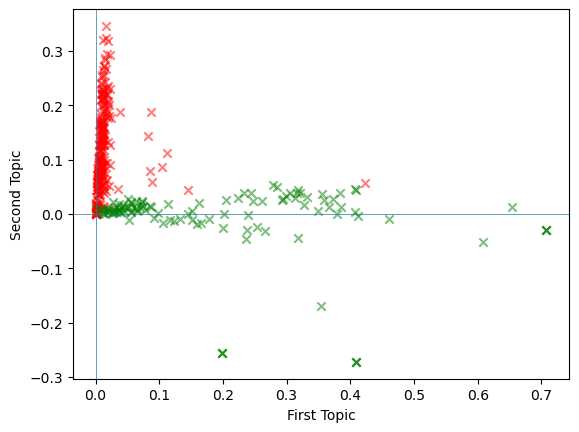

In [34]:
fig, ax = plt.subplots()

# I believe this should print trump in topic_1
for val in topic_encoded_df.Is_StPatricks.unique():
    topic_1 = topic_encoded_df[topic_encoded_df.Is_StPatricks == val]['Topic 1'].values
    topic_2 = topic_encoded_df[topic_encoded_df.Is_StPatricks == val]['Topic 2'].values
    color = "green" if val else "red" # if val means True
    label = "St Patricks" if val else "Trump Articles"
    ax.scatter(topic_1, topic_2, c = color, marker = 'x', alpha = 0.5, label = label)
    
ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth = 0.5)
ax.axhline(linewidth = 0.5)

In [35]:
topic_encoded_df['abs_topic_1'] = np.abs(topic_encoded_df['Topic 1'])
display(topic_encoded_df.sort_values('abs_topic_1', ascending = False))

,Topic 1,Topic 2,Sentence,Is_StPatricks,abs_topic_1
294,0.707957,-0.029473,Interested in trying out these team building a...,True,0.707957
323,0.707957,-0.029473,Interested in trying out these team building a...,True,0.707957
261,0.707957,-0.029473,Interested in trying out these team building a...,True,0.707957
270,0.654176,0.012060,This St. Patrick’s Day team-building fosters a...,True,0.654176
244,0.608755,-0.050989,This team-building activity promotes camarader...,True,0.608755
...,...,...,...,...,...
38,0.000116,-0.000054,Several dramatic steps appear to be in the works.,False,0.000116
231,-0.000014,-0.000033,Shame on you.,False,0.000014
163,0.000013,-0.000011,There’s nothing suspicious about that—any more...,False,0.000013
170,0.000010,0.000623,These are not acts of subversion.,False,0.000010


In [36]:
topic_encoded_df['abs_topic_2'] = np.abs(topic_encoded_df['Topic 2'])
display(topic_encoded_df.sort_values('abs_topic_2', ascending = False))

,Topic 1,Topic 2,Sentence,Is_StPatricks,abs_topic_1,abs_topic_2
118,0.015890,0.346259,"This week, Trump escalated his campaign agains...",False,0.015890,0.346259
157,0.015713,0.324864,"Like all attorneys, immigration lawyers are ta...",False,0.015713,0.324864
188,0.012006,0.319639,Immigration attorneys need access to detention...,False,0.012006,0.319639
146,0.019530,0.318511,These are the attorneys who represent clients ...,False,0.019530,0.318511
87,0.017200,0.294039,Among the other students targeted by the Trump...,False,0.017200,0.294039
...,...,...,...,...,...,...
330,0.379742,0.000475,“Celtic Dance Lessons” are a lively and energe...,True,0.379742,0.000475
211,-0.000001,-0.000086,"In 2022, Representative Zoe Lofgren introduced...",False,0.000001,0.000086
38,0.000116,-0.000054,Several dramatic steps appear to be in the works.,False,0.000116,0.000054
231,-0.000014,-0.000033,Shame on you.,False,0.000014,0.000033
